In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download l3llff/flowers


Dataset URL: https://www.kaggle.com/datasets/l3llff/flowers
License(s): CC0-1.0
 98% 223M/228M [00:02<00:00, 125MB/s] 
100% 228M/228M [00:02<00:00, 102MB/s]


In [6]:
!unzip "/content/flowers.zip"

Streaming output truncated to the last 5000 lines.
  inflating: flowers/magnolia/2090666304_0ff8463c5f_c.jpg  
  inflating: flowers/magnolia/20914736071_ede33a230a_c.jpg  
  inflating: flowers/magnolia/2126107417_92101f8b5f_c.jpg  
  inflating: flowers/magnolia/21500695820_bc9f753d79_c.jpg  
  inflating: flowers/magnolia/21986337916_36d1c95e64_c.jpg  
  inflating: flowers/magnolia/2294580412_50846f9130_c.jpg  
  inflating: flowers/magnolia/2300805045_982fa1bdf2_c.jpg  
  inflating: flowers/magnolia/2306786428_99f92b0d9c_c.jpg  
  inflating: flowers/magnolia/2324281515_c0269d5963_c.jpg  
  inflating: flowers/magnolia/2325102200_1cb9d8cabc_c.jpg  
  inflating: flowers/magnolia/2325102996_5f1e3bf13a_c.jpg  
  inflating: flowers/magnolia/2325370643_f452e88ace_c.jpg  
  inflating: flowers/magnolia/2334886646_c4c8ee532e_c.jpg  
  inflating: flowers/magnolia/23422365843_3b4b928a4a_c.jpg  
  inflating: flowers/magnolia/2365264040_1ff8f1fed3_c.jpg  
  inflating: flowers/magnolia/23678831170_c9b

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split

In [8]:
# define parameters
CLASS_NUM = 16
BATCH_SIZE = 16
EPOCH_STEPS = int(11332 / BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = '/content/flowers'
MODEL_NAME = 'googlenet_flower.h5'

In [9]:
# Initialize ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for testing

# Get the list of all image files
image_files = []
for root, dirs, files in os.walk(IMAGE_TRAIN):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Split the training set further into training and validation sets
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

# Create DataFrames for training, validation, and test sets
train_df = pd.DataFrame(train_files, columns=['file'])
train_df['label'] = train_df['file'].apply(lambda x: os.path.basename(os.path.dirname(x)))

val_df = pd.DataFrame(val_files, columns=['file'])
val_df['label'] = val_df['file'].apply(lambda x: os.path.basename(os.path.dirname(x)))

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['label'] = test_df['file'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Display the sizes of each dataset
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file',
    y_col='label',
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='file',
    y_col='label',
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file',
    y_col='label',
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Training set size: 11332
Validation set size: 1260
Test set size: 3148
Found 11332 validated image filenames belonging to 16 classes.
Found 1260 validated image filenames belonging to 16 classes.
Found 3148 validated image filenames belonging to 16 classes.


In [10]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)

    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)

    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)

    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)

    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])

    return model

In [11]:
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 64)           256       ['max_pooling2d[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor='accuracy', min_accuracy=0.85, patience=5, mode='max', verbose=1):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.min_accuracy = min_accuracy
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf if self.mode == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"Early stopping requires {self.monitor} available!")
            return

        if self.mode == 'max' and current > self.best:
            self.best = current
            self.wait = 0
        elif self.mode == 'min' and current < self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose:
                    print(f"\nEpoch {epoch+1}: Early stopping due to reaching {self.min_accuracy * 100}% accuracy for {self.patience} epochs without reduction.")

# Use the custom early stopping callback
custom_early_stop = CustomEarlyStopping(min_accuracy=0.85, patience=5, verbose=1)

# Increase epochs to 40
epochs = 55

optimizer = 'adam'

print('Using optimizer: ' + optimizer + ', Epochs: ' + str(epochs))

model.compile(loss='categorical_crossentropy',
              loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
              optimizer=optimizer, metrics=['accuracy'])

# Train the model with validation data
train_history = model.fit_generator(
    train_generator,
    steps_per_epoch=EPOCH_STEPS,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,  # Number of validation steps per epoch
    shuffle=True,
    callbacks=[custom_early_stop]
)

model.save(MODEL_NAME)


Using optimizer: adam, Epochs: 55


<ipython-input-12-f82361a4f2ff>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_history = model.fit_generator(


Epoch 1/55
 28/708 [>.............................] - ETA: 53:01 - loss: 4.5081 - main_loss: 2.8236 - aux1_loss: 2.8394 - aux2_loss: 2.7757 - main_accuracy: 0.0625 - aux1_accuracy: 0.0915 - aux2_accuracy: 0.0647

In [ ]:
history_dict = train_history.history
print(history_dict)

df_history = pd.DataFrame(history_dict)
df_history.to_csv('df_history_googlenet.csv', index = False)

{'loss': [3.3722243309020996, 2.788458824157715, 2.548609733581543, 2.304877996444702, 2.139465570449829, 2.018907308578491, 1.9267284870147705, 1.7934253215789795, 1.7058812379837036, 1.6083623170852661, 1.5775700807571411, 1.4790668487548828, 1.4016278982162476, 1.370031714439392, 1.3204494714736938, 1.2795681953430176, 1.2645591497421265, 1.1790755987167358, 1.14077889919281, 1.1279261112213135, 1.0745030641555786, 1.0373129844665527, 1.0325896739959717, 1.0097190141677856, 0.9519243836402893, 0.9554897546768188, 0.9282518029212952, 0.922420859336853, 0.9227505922317505, 0.8613728880882263, 0.8876481056213379, 0.843540608882904, 0.8285075426101685, 0.7920601963996887, 0.8139848709106445, 0.8170996904373169, 0.7834537625312805, 0.8196814060211182, 0.7605360150337219, 0.7524681687355042, 0.7544832229614258, 0.7730002403259277, 0.7434398531913757, 0.7153444886207581, 0.7079324722290039, 0.7090907096862793, 0.7128480076789856, 0.6965134143829346, 0.7431023716926575, 0.6733614802360535, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# /content/drive/MyDrive/DLCV GoogLeNet Weights

!cp googlenet_flower.h5 "/content/drive/MyDrive/DLCV GoogLeNet Weights/"


cp: cannot stat 'googlenet_flower.h5': No such file or directory


In [ ]:
# /content/drive/MyDrive/DLCV GoogLeNet Weights

!cp df_history_googlenet.csv "/content/drive/MyDrive/DLCV GoogLeNet Weights/"

cp: cannot stat 'df_history_googlenet.csv': No such file or directory


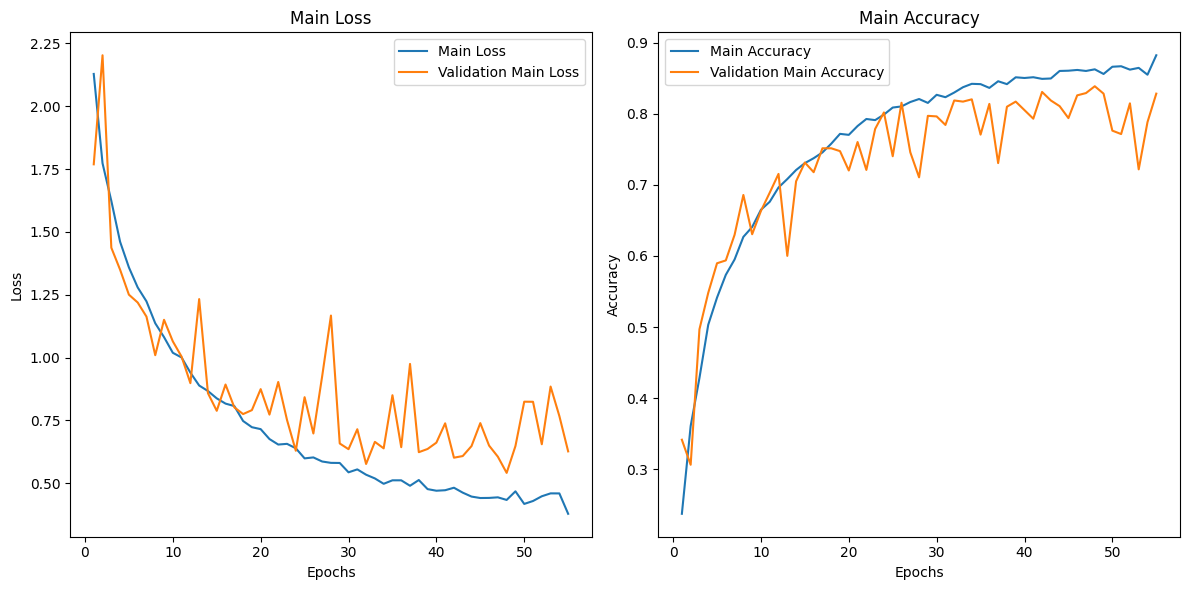

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['main_loss']) + 1)

    plt.figure(figsize=(12, 6))

    # Plotting main loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['main_loss'], label='Main Loss')
    plt.plot(epochs, history.history['val_main_loss'], label='Validation Main Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Main Loss')
    plt.legend()

    # Plotting main accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['main_accuracy'], label='Main Accuracy')
    plt.plot(epochs, history.history['val_main_accuracy'], label='Validation Main Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Main Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(train_history)


In [ ]:
# Evaluate the model on the test data generator
model = tf.keras.models.load_model('/content/drive/MyDrive/DLCV GoogLeNet Weights/googlenet_flower.h5')
evaluation = model.evaluate_generator(test_generator)

# This will return the loss value and any metrics defined during model compilation
print("Evaluation Loss:", evaluation[0])
print("Evaluation Metrics:", evaluation[1:])

<ipython-input-11-b794c3204185>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(test_generator)


Evaluation Loss: 0.7010307312011719
Evaluation Metrics: [0.4290938973426819, 0.44934895634651184, 0.45710816979408264, 0.8808767199516296, 0.8726175427436829, 0.8726175427436829]


1/1 [==============================] - 1s 841ms/step


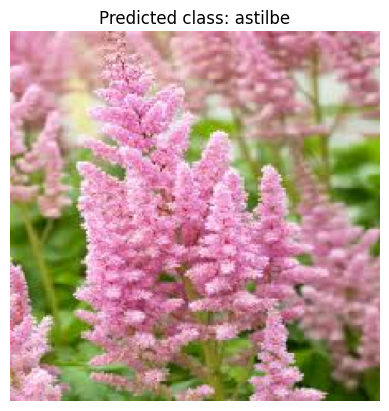

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/DLCV GoogLeNet Weights/googlenet_flower.h5')

# Assuming you have a custom image path
custom_image_path = '/content/astilbe.jpeg'

# Load and preprocess the custom image
img = tf.keras.preprocessing.image.load_img(custom_image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image

# Perform inference
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Assuming you have a list or dictionary of class names
class_names = ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the image and predicted class
plt.figure()
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()
